# Example: Evaluating the Performance of Minimum Variance Portfolios
Fill me in

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.

In [1]:
include("Include.jl");

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-5660-Examples-F23`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-5660-Examples-F23/Manifest.toml`


## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `10-31-2023`, along with data for a few exchange traded funds and volatility products during that time. In this block of code, we:
* Load and clean the historical data, we stored the clean data in the `dataset` variable.
* We calculate the expected excess return $\mathbb{E}(R_{i})$ for each `ticker` in `dataset`, however, we are only going to use the expected excess return for `SPY`, our benchmark portfolio
* We load the `single index models` estimated in `Lab 12c`, we store these models in the `sims` variable.
* We compute the expected excess return, and the covariance for each `ticker` in `dataset` using a `single index model`. These values are stored in the `μ_sim` and `Σ_sim` variables.

In [2]:
original_dataset = load(joinpath(_PATH_TO_DATA, "SP500-Daily-OHLC-1-3-2018-to-11-03-2023.jld2")) |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of tradition days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow

1470

In [4]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Let's get a list of firms that we have in cleaned up `dataset`, and save it ib the `all_tickers` array

In [5]:
all_tickers = keys(dataset) |> collect |> sort;

Finally, let's set some constant values, e.g., the `risk_free_rate`

In [6]:
risk_free_rate = 0.05;

### Compute the covariance and expected yield for all firms in the dataset
The expected return $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll provide values for both of these items for the entire data set (all `N = 459` tickers), and then you can pick out which tickers you are interested in. 

* First, we compute the expected (annualized) log return by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the `log_return_matrix(...)` method. The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time-value, while each column corresponds to a firm:

In [7]:
all_firms_excess_return_matrix = log_return_matrix(dataset, all_tickers, 
    Δt = (1.0/252.0), risk_free_rate = risk_free_rate);

Next, we estimate the expected excess return for each firm from the `all_firms_excess_return_matrix` using the `mean(...)` function, which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We set the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(R_{1}),\dotsc,\mathbb{E}(R_{N})$ in the variable $\mu$:

In [8]:
μ = mean(all_firms_excess_return_matrix, dims=1) |> vec;

### Build single index model returns and covariance

In [9]:
sims = load(joinpath(_PATH_TO_DATA, "SIM-SP500-01-03-18-to-10-31-23.jld2")) |> x->x["sim"];

Store the index of the market portfolio in the `index_SPY` variable, and then the expected return of the market portfolio $\mathbb{E}(R_{m})$ in the `R_SPY` vector:

In [10]:
index_SPY = findfirst(x->x=="SPY", all_tickers);
R_SPY = μ[index_SPY]

0.03162581610107127

Now, compute the expected return for each ticker in `dataset` using the `single index models` computed in `Lab 12b` using a `for` loop. For iteration of the loop:
* Get the `ticker` symbol from the `all_tickers` array, and pull out the corresponding `single index model` from the `sims` dictionary
* Next, pull out the $(\alpha, \beta)$ parameters from the `sim` model instance and compute the expected return $\mathbb{E}(R_{i})$. Store the expected return in the `μ_sim` array

In [11]:
μ_sim = Array{Float64,1}();
for i ∈ eachindex(all_tickers)
    
    myticker = all_tickers[i];
    sim = sims[myticker];
    
    αᵢ = sim.α
    βᵢ = sim.β
    Rᵢ = αᵢ+βᵢ*R_SPY
    
    push!(μ_sim,Rᵢ)
end

Next let's build the `single index model` version of the covariance array. Substituting the single index model for the excess return of asset $i$ and $j$ into the covariance expression (and simplifying) gives:

$$
\begin{equation*}
\text{cov}(R_{i}, R_{j}) = \begin{cases}
\beta_{i}^{2}\sigma_{m}^{2}+\sigma_{\epsilon_{i}}^{2} & i = j \\
\beta_{i}\beta_{j}\sigma_{m}^2 & i \neq j
\end{cases}
\end{equation*}
$$

where $\sigma_{m}^2$ denotes the variance of the excess return of the market,  and $\sigma_{\epsilon_{i}}^{2}$ denotes the variance of the firm-specific error model.

In [12]:
σₘ = std(all_firms_excess_return_matrix[:, index_SPY]);

We populate the single index covariance array using nested `for` loops:

In [13]:
Σ_tmp = Array{Float64,2}(undef, length(μ), length(μ));
for i ∈ eachindex(all_tickers)
    outer_ticker = all_tickers[i];
    sim_outer = sims[outer_ticker];
    
    for j ∈ eachindex(all_tickers)
        
        inner_ticker = all_tickers[j];
        sim_inner = sims[inner_ticker];
        
        if (i == j)
            βᵢ = sim_outer.β
            ϵᵢ = sim_outer.ϵ
            σ_ϵᵢ = params(ϵᵢ)[2];
            Σ_tmp[i,j] = ((βᵢ)^2)*((σₘ)^2)+(σ_ϵᵢ)^2
        else
            βᵢ = sim_outer.β
            βⱼ = sim_inner.β
            Σ_tmp[i,j] = βᵢ*βⱼ*(σₘ)^2
        end
    end
end
Σ_sim  = Σ_tmp |> x-> x*(1/252);

In [14]:
𝒟(r,t) = exp(r*t);

## Task 1: Select tickers for your `risky-only` portfolio
Before we compute the efficient frontier, we must decide which stocks to include in the risky portfolio. One strategy is to pick stocks that have small or even negative covariance. Let's explore this idea. 

* Specify a collection of `ticker symbols`, e.g., `AAPL`, `MSFT`, etc., that interest you in the `my_list_of_tickers` array. We'll  put the indexes of your tickers in the `my_list_of_firm_ids` array:

In [15]:
my_list_of_tickers = ["AAPL", "INTC", "MSFT", "MU", "AMD", "GS", "BAC", "WFC", "C", "F", "PFE", "MRK"];
my_list_of_firm_ids = Array{Int64,1}();
for ticker ∈ my_list_of_tickers
    firm_index = findfirst(x->x==ticker, all_tickers);    
    push!(my_list_of_firm_ids, firm_index)
end

Now that you have selected the firms in your risky portfolio, we'll compute for you the firm-specific expected return vector and covariance matrix. We'll store these in the $\hat{\mu}$ and $\hat{\Sigma}$ variables. First, we'll construct the $\hat{\mu}$ vector for the `data` and `single index model` versions of the problem:

In [16]:
# --- DO NOT CHANGE THIS BLOCK ----------------------------------------- #
μ̂_sim = Array{Float64,1}();
for firm_index ∈ my_list_of_firm_ids
    push!(μ̂_sim, μ_sim[firm_index])
end
# ---------------------------------------------------------------------- #

and then we'll compute the firm-specific covariance $\hat{\Sigma}$ matrix for the `data` version of the problem:

In [17]:
# --- DO NOT CHANGE THIS BLOCK FOR SIM  -------------------------------- #
my_number_of_selected_firms = length(my_list_of_firm_ids)
Σ̂_sim = Array{Float64,2}(undef, my_number_of_selected_firms, my_number_of_selected_firms);
for i ∈ eachindex(my_list_of_firm_ids)
    row_firm_index = my_list_of_firm_ids[i]
    for j ∈ eachindex(my_list_of_firm_ids)
        col_firm_index = my_list_of_firm_ids[j]
        Σ̂_sim[i,j] = Σ_sim[row_firm_index, col_firm_index]
    end
end
# ---------------------------------------------------------------------- #

## Task 2: Compute the efficient frontier for your collection of stocks
Create an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, and store this in the `problem_risk` variable using the `build(...)` method. You'll need to pass your covariance array $\hat{\Sigma}$, the expected return array $\hat{\mu}$, along with bounds and an initial guess, to the `build(...)` method. 

Let's setup the bounds, and some other constants:

In [18]:
number_of_firms = length(my_list_of_tickers);
wₒ = zeros(number_of_firms);
wₒ[1] = 1.0;
bounds = zeros(number_of_firms,2);
bounds[:,2] .= 1.0;
number_of_points = 40;

and the build an instance of the `MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem` type, using the `build(...)` method. Save the `data` version of the problem in the `problem_risk` variable:

In [19]:
problem_risk_sim = build(MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem, (
    Σ = Σ̂_sim,
    μ = μ̂_sim,
    bounds = bounds,
    initial = wₒ,
    R = 0.0
));

Next, we create an array with the minimum desired rewards (the calculation must achieve at least this much reward). We store these values in the `minimum_desired_reward_array` variable:

In [20]:
minimum_desired_reward_array = range(0.0, stop = 0.5 - risk_free_rate, length = number_of_points) |> collect;

Finally, we iterate through the `minimum_desired_reward_array` and compute the minimum risk required to achieve the specified reward level using a `for-loop`. In particular, for each pass through the loop, we:
* Update the `problem_risk` variable with the minimum desired reward
* We then pass the updated `problem` object to the `solve(...)` method (which initializes and solves the optimization problem). The solution returned from the `solve(...)` method is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store the solution in the `frontier` dictionary.

In [21]:
efficient_frontier_sim = Dict{Float64,Float64}();
for i ∈ eachindex(minimum_desired_reward_array)
    
    # update the problem object -
    problem_risk_sim.R = minimum_desired_reward_array[i];
    
    # compute -
    solution_sim = solve(problem_risk_sim)

    # check: did this converge?
    status_flag = solution_sim["status"];    
    if (status_flag == MathOptInterface.LOCALLY_SOLVED)
        key = sqrt(solution_sim["objective_value"]);
        value = solution_sim["reward"];
        efficient_frontier_sim[key] = value;
    end
end
efficient_frontier_sim

Dict{Float64, Float64} with 29 entries:
  0.154649 => 0.0346158
  0.154577 => 0.0268557
  0.154577 => 0.0268557
  0.270247 => 0.242308
  0.368719 => 0.288462
  0.154577 => 0.0268556
  0.188326 => 0.161538
  0.161427 => 0.0923077
  0.291687 => 0.253846
  0.155808 => 0.0576924
  0.341382 => 0.276923
  0.397268 => 0.3
  0.204903 => 0.184615
  0.164519 => 0.103846
  0.181968 => 0.15
  0.237284 => 0.219231
  0.251875 => 0.230769
  0.315569 => 0.265385
  0.176867 => 0.138462
  0.225648 => 0.207692
  0.155026 => 0.0461538
  0.157066 => 0.0692308
  0.172273 => 0.126923
  0.214825 => 0.196154
  0.426785 => 0.311538
  ⋮        => ⋮

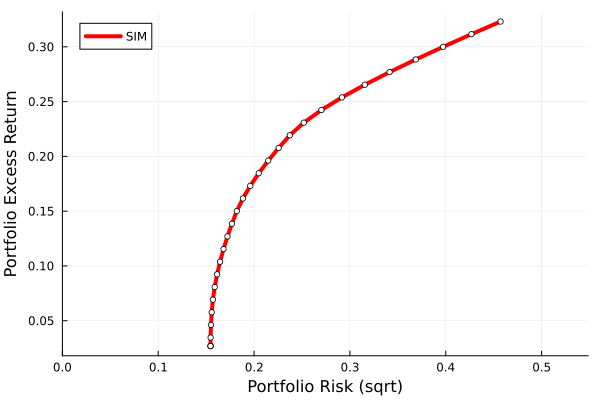

In [22]:
# single index model -
plot(efficient_frontier_sim, lw=4, xlabel="Portfolio Risk (sqrt)", 
    ylabel="Portfolio Excess Return", fontsize=18, label="SIM", c=:red, 
    xlim=(0.0, 1.2*maximum(efficient_frontier_sim).first))
scatter!(efficient_frontier_sim, label="", c=:white, mec=:red, ms=3)

## Task 3: Evalute the performance of a `SIM` portfolio
Suppose we invested `Wₒ USD` in a portfolio that lies along the efficient frontier. What can we expect that portfolio to be worth at $t\geq{t_{o}}$?

In [43]:
Wₒ = 100.0;
number_of_trading_days = 62;
offset = 1358;

Pick a random portfolio from the `efficient_frontier_sim`:

In [24]:
P = rand(efficient_frontier_sim);
μₚ = P.second;
σₚ = P.first;

In [25]:
P

0.2916867516691598 => 0.2538461439330758

In [26]:
wealth_array = Array{Float64,2}(undef, number_of_trading_days, 8);
for i ∈ 1:number_of_trading_days
    Δt = (i-1)*(1/252);
    
    wealth_array[i,1] = Δt
    wealth_array[i,2] = Wₒ*exp((μₚ + risk_free_rate)*Δt);
    wealth_array[i,3] = Wₒ*exp((μₚ - σₚ + risk_free_rate)*Δt);
    wealth_array[i,4] = Wₒ*exp((μₚ + σₚ + risk_free_rate)*Δt);
    wealth_array[i,5] = Wₒ*exp((μₚ - 1.96*σₚ + risk_free_rate)*Δt);
    wealth_array[i,6] = Wₒ*exp((μₚ + 1.96*σₚ + risk_free_rate)*Δt);
    wealth_array[i,7] = Wₒ*exp((μₚ - 2.576*σₚ + risk_free_rate)*Δt);
    wealth_array[i,8] = Wₒ*exp((μₚ + 2.576*σₚ + risk_free_rate)*Δt);
end

In [27]:
wealth_array

62×8 Matrix{Float64}:
 0.0         100.0    100.0    100.0    100.0     100.0    100.0     100.0
 0.00396825  100.121  100.005  100.237   99.8938  100.348   99.8226  100.42
 0.00793651  100.241  100.01   100.474   99.7876  100.697   99.6454  100.841
 0.0119048   100.362  100.014  100.711   99.6816  101.048   99.4686  101.264
 0.015873    100.483  100.019  100.95    99.5757  101.399   99.2921  101.689
 0.0198413   100.605  100.024  101.189   99.4699  101.752   99.116   102.116
 0.0238095   100.726  100.029  101.428   99.3643  102.107   98.9401  102.544
 0.0277778   100.848  100.034  101.668   99.2587  102.462   98.7645  102.975
 0.031746    100.969  100.039  101.909   99.1533  102.819   98.5893  103.407
 0.0357143   101.091  100.043  102.15    99.0479  103.176   98.4144  103.841
 0.0396825   101.213  100.048  102.391   98.9427  103.535   98.2397  104.276
 0.0436508   101.335  100.053  102.634   98.8376  103.896   98.0654  104.714
 0.047619    101.457  100.058  102.876   98.7326  104.257

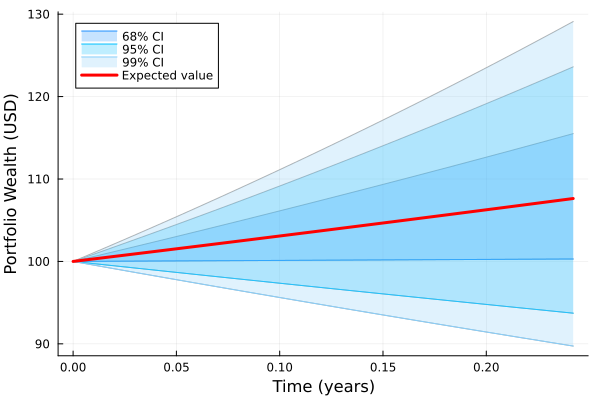

In [28]:
p = plot();
plot!(wealth_array[:,1],wealth_array[:,3],lw=1,label="",c=:gray69)
plot!(wealth_array[:,1],wealth_array[:,4],lw=1,label="", c=:gray69)
plot!(wealth_array[:,1],wealth_array[:,5],lw=1,label="", c=:gray69)
plot!(wealth_array[:,1],wealth_array[:,6],lw=1,label="", c=:gray69)
plot!(wealth_array[:,1],wealth_array[:,7],lw=1,label="", c=:gray69)
plot!(wealth_array[:,1],wealth_array[:,8],lw=1,label="", c=:gray69)

L68 = wealth_array[:,3];
U68 = wealth_array[:,4];
plot!(wealth_array[:,1], L68, fillrange = U68, fillalpha = 0.25, c = :dodgerblue, label = "68% CI")

L95 = wealth_array[:,5];
U95 = wealth_array[:,6];
plot!(wealth_array[:,1], L95, fillrange = U95, fillalpha = 0.25, c = :deepskyblue, label = "95% CI")

L99 = wealth_array[:,7];
U99 = wealth_array[:,8];
plot!(wealth_array[:,1], L99, fillrange = U99, fillalpha = 0.25, c = :lightskyblue, label = "99% CI")

plot!(wealth_array[:,1],wealth_array[:,2],lw=3,label="Expected value", c=:red)
xlabel!("Time (years)", fontsize=18)
ylabel!("Portfolio Wealth (USD)", fontsize=18)

In [29]:
WFP = wealth_array[end,2] |> x-> round(x,digits=2);
WFP_LB = wealth_array[end,3] |> x-> round(x,digits=2)
WFP_UB = wealth_array[end,4] |> x-> round(x,digits=2)
println("The selected portfolio should be worth (L,E,U) = ($(WFP_LB), $(WFP), $(WFP_UB)) USD")

The selected portfolio should be worth (L,E,U) = (100.29, 107.63, 115.51) USD


In [30]:
Δt = (number_of_trading_days/252);
NPV_P = -Wₒ + (1/𝒟(risk_free_rate, Δt))*WFP
println("The expected NPV for this portfolio is NPV = $(NPV_P)")

The expected NPV for this portfolio is NPV = 6.31409064023282


## Benchmark: What does `SPY` look like?

In [44]:
σ̄ₘ = σₘ*sqrt(1/252) # correct for annualized std dev
wealth_array_SPY = Array{Float64,2}(undef, number_of_trading_days, 8);
for i ∈ 1:number_of_trading_days
    Δt = (i-1)*(1/252);
    
    wealth_array_SPY[i,1] = Δt
    wealth_array_SPY[i,2] = Wₒ*exp((R_SPY + risk_free_rate)*Δt);
    wealth_array_SPY[i,3] = Wₒ*exp((R_SPY - σ̄ₘ + risk_free_rate)*Δt);
    wealth_array_SPY[i,4] = Wₒ*exp((R_SPY + σ̄ₘ + risk_free_rate)*Δt);
    wealth_array_SPY[i,5] = Wₒ*exp((R_SPY - 1.96*σ̄ₘ + risk_free_rate)*Δt);
    wealth_array_SPY[i,6] = Wₒ*exp((R_SPY + 1.96*σ̄ₘ + risk_free_rate)*Δt);
    wealth_array_SPY[i,7] = Wₒ*exp((R_SPY - 2.576*σ̄ₘ + risk_free_rate)*Δt);
    wealth_array_SPY[i,8] = Wₒ*exp((R_SPY + 2.576*σ̄ₘ + risk_free_rate)*Δt);
end

In [45]:
SPY_actual = Array{Float64,2}(undef, number_of_trading_days, 2);
SPY_data = dataset["SPY"];
SPY_return = Array{Float64,1}(undef, number_of_trading_days);
for j ∈ 2:number_of_trading_days+1
    date_index = (j - 1) + offset;
    S₁ = SPY_data[(date_index - 1), :volume_weighted_average_price];
    S₂ = SPY_data[date_index, :volume_weighted_average_price];
    SPY_return[j-1] = log(S₂/S₁);
end

Wᵢ = Wₒ
SPY_actual[1,2] = Wₒ
for i ∈ 2:(number_of_trading_days)
    Δt = (i-1)*(1/252);
    
    
    SPY_actual[i,1] = Δt
    SPY_actual[i,2] = Wᵢ*exp(SPY_return[i]);
    Wᵢ = SPY_actual[i,2];
end

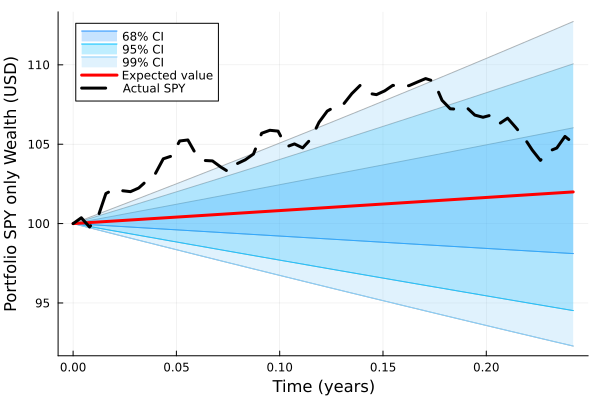

In [46]:
p = plot();
plot!(wealth_array_SPY[:,1],wealth_array_SPY[:,3],lw=1,label="",c=:gray69)
plot!(wealth_array_SPY[:,1],wealth_array_SPY[:,4],lw=1,label="", c=:gray69)
plot!(wealth_array_SPY[:,1],wealth_array_SPY[:,5],lw=1,label="", c=:gray69)
plot!(wealth_array_SPY[:,1],wealth_array_SPY[:,6],lw=1,label="", c=:gray69)
plot!(wealth_array_SPY[:,1],wealth_array_SPY[:,7],lw=1,label="", c=:gray69)
plot!(wealth_array_SPY[:,1],wealth_array_SPY[:,8],lw=1,label="", c=:gray69)

L68 = wealth_array_SPY[:,3];
U68 = wealth_array_SPY[:,4];
plot!(wealth_array_SPY[:,1], L68, fillrange = U68, fillalpha = 0.25, c = :dodgerblue, label = "68% CI")

L95 = wealth_array_SPY[:,5];
U95 = wealth_array_SPY[:,6];
plot!(wealth_array_SPY[:,1], L95, fillrange = U95, fillalpha = 0.25, c = :deepskyblue, label = "95% CI")

L99 = wealth_array_SPY[:,7];
U99 = wealth_array_SPY[:,8];
plot!(wealth_array_SPY[:,1], L99, fillrange = U99, fillalpha = 0.25, c = :lightskyblue, label = "99% CI")

plot!(wealth_array_SPY[:,1],wealth_array_SPY[:,2],lw=3,label="Expected value", c=:red)
plot!(SPY_actual[:,1], SPY_actual[:,2],lw=3,c=:black,ls=:dash, label="Actual SPY")

xlabel!("Time (years)", fontsize=18)
ylabel!("Portfolio SPY only Wealth (USD)", fontsize=18)

In [35]:
WFSPY = wealth_array_SPY[end,2] |> x-> round(x,digits=2);
WFSPY_LB = wealth_array_SPY[end,3] |> x-> round(x,digits=2)
WFSPY_UB = wealth_array_SPY[end,4] |> x-> round(x,digits=2)
println("SPY only portfolio should be worth (L,E,U) = ($(WFSPY_LB), $(WFSPY), $(WFSPY_UB)) USD")

SPY only portfolio should be worth (L,E,U) = (98.11, 102.0, 106.03) USD


In [36]:
Δt = (number_of_trading_days/252);
NPV_SPY = -Wₒ + (1/𝒟(risk_free_rate, Δt))*WFSPY
println("The expected NPV for this portfolio is NPV = $(NPV_SPY)")

The expected NPV for this portfolio is NPV = 0.7529243268953678
